In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split, array_contains, lit
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

Load crash_weather data

In [2]:
#read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/collision_weather.csv", inferSchema=True, header=True)

df.show(2)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/04 23:51:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/04 23:51:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/04 23:51:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/04 23:51:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/12/04 23:51:44 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+
|    simp_date| borough|zip code| latitude|longitude|            location|on street name|cross street name|     off street name|number of persons injured|number of persons killed|number of ped

Preprocess
Encode string columns

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [4]:
df = df.withColumn('hour', split(df['simp_date'], ' ').getItem(1).astype("int"))

numericCols = ["hour", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m (°)"]
df = df.dropna(subset=numericCols)
#df = df.drop('simp_date')

In [5]:
'''setCategoricalColumns = ["contributing factor vehicle", "vehicle type code"]
categoricalSetList = {}
for categoricalCol in setCategoricalColumns:
    categoricalSet = set()
    for i in range(1, 6):
        name = categoricalCol + ' ' + str(i)
        categoricalSet.update([x[name] for x in df.select(name).distinct().collect()])
    categoricalSetList[categoricalCol] = list(categoricalSet)

for categoricalCol in categoricalSetList.keys():
    print(categoricalCol, len(categoricalSetList[categoricalCol]))'''


'setCategoricalColumns = ["contributing factor vehicle", "vehicle type code"]\ncategoricalSetList = {}\nfor categoricalCol in setCategoricalColumns:\n    categoricalSet = set()\n    for i in range(1, 6):\n        name = categoricalCol + \' \' + str(i)\n        categoricalSet.update([x[name] for x in df.select(name).distinct().collect()])\n    categoricalSetList[categoricalCol] = list(categoricalSet)\n\nfor categoricalCol in categoricalSetList.keys():\n    print(categoricalCol, len(categoricalSetList[categoricalCol]))'

In [6]:
df_concat = df.withColumn("contributing factor", concat_ws("  ", col("contributing factor vehicle 1"), col("contributing factor vehicle 2")\
                                               , col("contributing factor vehicle 3"), col("contributing factor vehicle 4")\
                                               , col("contributing factor vehicle 5")))\
    .withColumn("contributing factor", split(col("contributing factor"), "  "))
df_concat = df_concat.drop("contributing factor vehicle 1", "contributing factor vehicle 2", "contributing factor vehicle 3"\
             , "contributing factor vehicle 4", "contributing factor vehicle 5")

df_concat = df_concat.withColumn("vehicle type code", concat_ws("  ", col("vehicle type code 1"), col("vehicle type code 2"), col("vehicle type code 3")\
                                                  , col("vehicle type code 4"), col("vehicle type code 5")))\
    .withColumn("vehicle type code", split(col("vehicle type code"), "  "))
df_concat = df_concat.drop("vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5")

df_concat.select("contributing factor", "vehicle type code").show(3)

+--------------------+-----------------+
| contributing factor|vehicle type code|
+--------------------+-----------------+
|       [Unspecified]|          [Sedan]|
|[Unspecified, Uns...|   [Sedan, Sedan]|
|[Driver Inexperie...|          [Sedan]|
+--------------------+-----------------+
only showing top 3 rows



In [7]:
# explode based on columns vehicle type code and contributing factor
rdd = df_concat.select(["collision_id", "vehicle type code"]).rdd
rdd = rdd.flatMap(lambda x: [(x[0], x1) for x1 in x[1]])
df_epd = rdd.toDF(["collision_id", "vehicle type code"])
df_epd = df_epd.join(df_concat.drop("vehicle type code"), on="collision_id", how='inner')
df_epd.select(["collision_id", "vehicle type code"]).show(6)

+------------+--------------------+
|collision_id|   vehicle type code|
+------------+--------------------+
|     4456314|               Sedan|
|     4486660|               Sedan|
|     4486660|               Sedan|
|     4487074|               Sedan|
|     4486519|               Sedan|
|     4486519|Station Wagon/Spo...|
+------------+--------------------+
only showing top 6 rows



In [8]:
stages = []
categoricalColumns = ["borough","zip code","on street name","cross street name","off street name", "contributing factor vehicle 1",\
    "contributing factor vehicle 2","contributing factor vehicle 3", "contributing factor vehicle 4", "contributing factor vehicle 5", \
    "vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5"]
for categoricalCol in categoricalColumns:
    # use StringIndexer to Category Indexing
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index").setHandleInvalid("keep")
    # use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "Vec"])
    stages += [stringIndexer, encoder]

In [9]:
# transform all features into a vector using VectorAssembler
numericCols = ["hour", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m (°)"]
assemblerInputs = [c + "Vec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [10]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df1 = pipelineModel.transform(df)

df1.show(1)

22/12/04 23:52:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 29.7 MiB


+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+----+------------+-------------+-------------+---------------+-------------------+-----------------+----------------------+--------------------+--------------------+--------------------+-------

Correlation

In [11]:
from pyspark.ml.stat import Correlation

In [12]:
cor_list = ["number of persons injured", "number of persons killed"] + numericCols + [c + "Index" for c in categoricalColumns]
df_cor = df1.select(cor_list).dropna()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_cor.columns, outputCol=vector_col)
df_vector = assembler.transform(df_cor).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

22/12/04 23:52:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:52:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:53:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:53:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


In [13]:
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = cor_list, index=cor_list) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

,number of persons injured,number of persons killed,hour,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),boroughIndex,zip codeIndex,on street nameIndex,cross street nameIndex,off street nameIndex,contributing factor vehicle 1Index,contributing factor vehicle 2Index,contributing factor vehicle 3Index,contributing factor vehicle 4Index,contributing factor vehicle 5Index,vehicle type code 1Index,vehicle type code 2Index,vehicle type code 3Index,vehicle type code 4Index,vehicle type code 5Index
number of persons injured,1.00,0.02,0.03,0.05,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.02,-0.03,-0.12,-0.11,0.10,0.05,0.08,-0.12,-0.08,-0.05,0.00,0.02,-0.12,-0.09,-0.05
number of persons killed,0.02,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.02,-0.01,0.01,0.01,0.03,-0.01,-0.02,-0.02,0.00,0.02,-0.01,-0.02,-0.02
hour,0.03,-0.00,1.00,0.14,0.02,0.02,0.07,0.05,0.06,-0.00,0.10,0.01,-0.01,-0.00,-0.02,-0.02,0.01,-0.04,-0.01,0.04,0.03,0.02,-0.01,-0.02,0.04,0.03,0.02
temperature_2m (°C),0.05,0.00,0.14,1.00,0.02,0.05,-0.00,-0.02,-0.09,0.05,-0.20,-0.06,-0.00,-0.01,0.03,0.03,-0.03,-0.02,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,-0.01,-0.00,-0.00
precipitation (mm),-0.00,0.00,0.02,0.02,1.00,0.97,0.30,0.30,0.35,0.22,0.15,-0.15,-0.00,0.00,-0.00,-0.00,0.00,0.01,0.01,0.00,0.00,-0.00,-0.00,0.01,0.00,0.00,-0.00
rain (mm),0.00,0.00,0.02,0.05,0.97,1.00,0.29,0.29,0.32,0.21,0.12,-0.14,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,0.01,0.00,-0.00,-0.00
cloudcover (%),-0.00,-0.00,0.07,-0.00,0.30,0.29,1.00,0.80,0.73,0.52,0.06,-0.32,-0.00,-0.00,-0.01,-0.00,0.00,0.00,0.01,0.01,0.00,0.00,-0.00,0.00,0.01,0.00,0.00
cloudcover_low (%),-0.01,-0.00,0.05,-0.02,0.30,0.29,0.80,1.00,0.40,0.18,0.11,-0.28,-0.00,0.00,-0.00,-0.00,0.00,-0.01,0.01,0.01,0.01,0.00,-0.00,0.00,0.01,0.01,0.00
cloudcover_mid (%),-0.00,-0.00,0.06,-0.09,0.35,0.32,0.73,0.40,1.00,0.37,0.11,-0.23,0.00,0.00,-0.01,-0.01,0.01,0.01,0.01,0.00,0.00,-0.00,-0.00,0.01,0.00,0.00,-0.00
cloudcover_high (%),-0.00,-0.00,-0.00,0.05,0.22,0.21,0.52,0.18,0.37,1.00,-0.08,-0.24,-0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00


<AxesSubplot:>

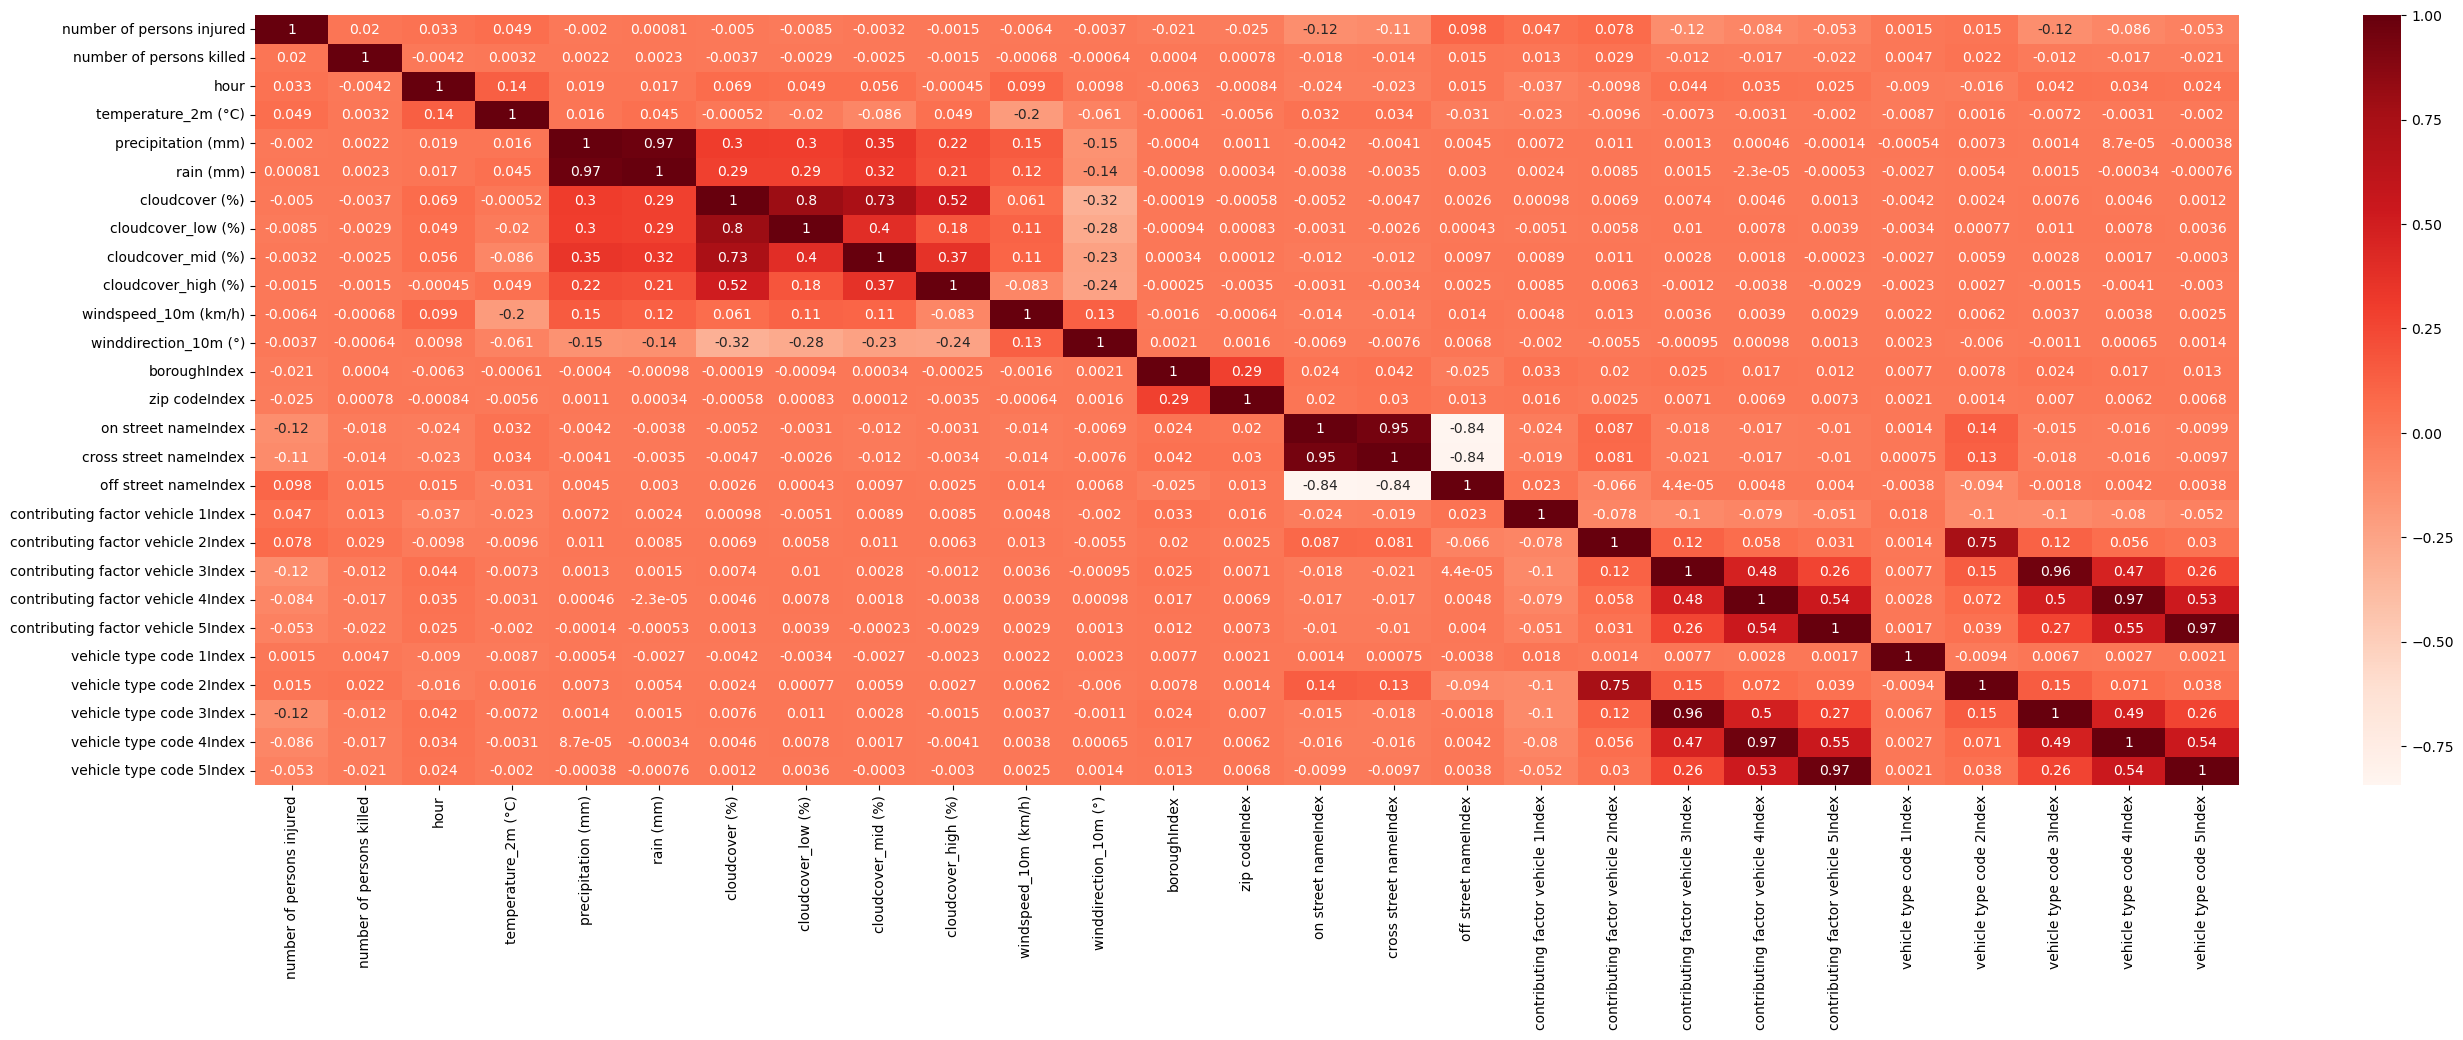

In [14]:
plt.figure(figsize=(32,10))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Reds", annot=True)